In [1]:
import os
import random
import string
import re
import requests
import gzip
import shutil
import json
import types
import datetime
import decimal
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt

endpoint = "http://193.171.177.138:9999/blazegraph/sparql"  # SPARQL endpoint hosting previous version of ITO.owl
prefixes = """
prefix owl: <http://www.w3.org/2002/07/owl#>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix ito: <https://identifiers.org/ito:>
prefix edam: <http://edamontology.org/>
prefix obo: <http://www.geneontology.org/formats/oboInOwl#>
prefix dc: <http://purl.org/dc/elements/1.1/>
"""


def query(query, return_format = JSON):
    sparql = SPARQLWrapper(endpoint)
    sparql.method = 'POST'
    sparql.setReturnFormat(return_format)
    sparql.setQuery(prefixes + query)
    results = sparql.query().convert()
    return results


def query_df(query, numeric_cols = []):
    # Run SPARQL query, and convert results to Pandas dataframe
    sparql = SPARQLWrapper(endpoint)
    sparql.method = 'POST'
    sparql.setReturnFormat(JSON)
    sparql.setQuery(prefixes + query)
    results = sparql.query()
    processed_results = json.load(results.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)
        
    df = pd.DataFrame(out, columns=cols)
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col])
    
    return df

def tasks_stat_dict(df):
    from collections import defaultdict
    tasks_stat = defaultdict(int)
    for idx, row in df.iterrows():
        for task in row["tasks"]:
            tasks_stat[task] += 1
    return dict(sorted(tasks_stat.items(), key=lambda x: x[1], reverse=True))
    

In [2]:
filename = './datasets.json.gz'
if not os.path.exists(filename):
    url = 'https://paperswithcode.com/media/about/datasets.json.gz'
    myfile = requests.get(url)
    with open(filename, 'wb') as o:
        o.write(myfile.content)
    with gzip.open(filename, 'rb') as f_in:
        with open('./datasets.json', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

with open('datasets.json') as f:
    datasets_ = json.load(f)
    
variant_to_parent = dict()
variant_to_url = dict()
# unprioritize independency
for dataset in datasets_:
    variant_to_parent[dataset["name"]] = dataset["name"]
    variant_to_url[dataset["name"]] = dataset["url"]
for dataset in datasets_:
    ## create variant_to_parent mapping 
    for variant in dataset["variants"]:
        if dataset["name"] != variant:
            variant_to_parent[variant] = dataset["name"]
            variant_to_url[dataset["name"]] = dataset["url"]

Description whole df
       n_entries    n_tasks
count  49.000000  49.000000
mean    8.551020   1.448980
std     9.235487   0.891189
min     1.000000   1.000000
25%     2.000000   1.000000
50%     6.000000   1.000000
75%    12.000000   2.000000
max    50.000000   5.000000
Length popular 13
Length unpopular 13


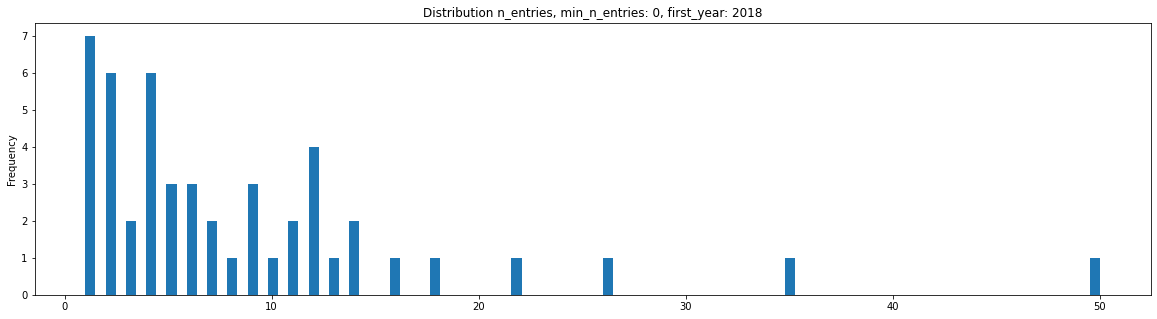

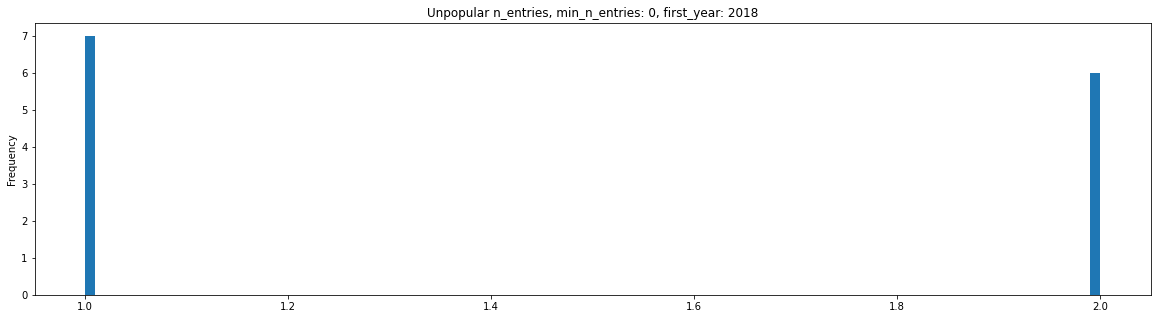

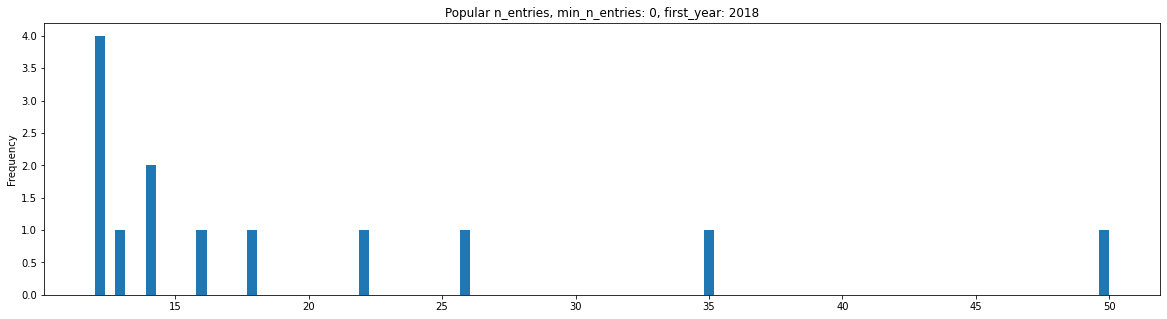

In [3]:
first_year = 2018
min_n_entries = 0
prefix="nlp"
root = "https://identifiers.org/ito:ITO_00141"

df = query_df("""
SELECT * WHERE {
    ?benchmark rdfs:subClassOf+ <""" + root + """> .
    ?benchmark rdfs:subClassOf <https://identifiers.org/ito:Benchmarking> .
    ?benchmark rdfs:label ?benchmark_label .
    ?result rdf:type ?benchmark .
    ?result obo:date ?date .
}
""")
df["benchmark_label"] = df["benchmark_label"].str.replace(" benchmarking", "")
df[["benchmark_label", "task_label"]] = df["benchmark_label"].str.split(' - ', 1, expand=True)
df["date"] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.sort_values(by="date")

df["benchmark_label"] = df["benchmark_label"].apply(lambda x: variant_to_parent.get(x, None))
df = df.dropna(subset=["benchmark_label"])

def agg(examples):
    examples = examples.sort_values(by="date")
    return pd.Series({"first_date": examples.iloc[0]["date"], "n_entries": len(examples), "n_tasks": len(set(examples["task_label"])), "tasks": set(examples["task_label"])})

df = df.groupby(["benchmark_label"])[["result", "date", "task_label"]].apply(agg).reset_index()
df["url"] = df["benchmark_label"].apply(lambda x: variant_to_url.get(x, None))
df = df.sort_values(by="n_entries", ascending=False)

df.to_csv(f"{prefix}_all_unfiltered.csv", index=None)

# filter year
if first_year > -1:
    df = df[df['first_date'].dt.year == first_year]

# filter n_entries
df = df[df.n_entries >= min_n_entries]

description = df.describe()
print("Description whole df")
print(description)

plt.figure();
df["n_entries"].plot.hist(stacked=True, bins=100, figsize=(20,5), title=f"Distribution n_entries, min_n_entries: {min_n_entries}, first_year: {first_year}");

unpopular = df[df.n_entries <= float(description["n_entries"].loc["25%"])]
popular = df[df.n_entries >= float(description["n_entries"].loc["75%"])]

popular.to_csv(f"{prefix}_popular.csv", index=None)
unpopular.to_csv(f"{prefix}_unpopular.csv", index=None)

print(f"Length popular {len(popular)}")
print(f"Length unpopular {len(unpopular)}")

plt.figure();
unpopular["n_entries"].plot.hist(stacked=True, bins=100, figsize=(20,5), title=f"Unpopular n_entries, min_n_entries: {min_n_entries}, first_year: {first_year}");
plt.figure();
popular["n_entries"].plot.hist(stacked=True, bins=100, figsize=(20,5), title=f"Popular n_entries, min_n_entries: {min_n_entries}, first_year: {first_year}");

In [4]:
popular.iloc[0:30]

,benchmark_label,first_date,n_entries,n_tasks,tasks,url
355,SuperGLUE,2018-10-11,50,5,"{Word Sense Disambiguation, Coreference Resolu...",https://paperswithcode.com/dataset/superglue
207,MLDoc,2018-05-24,35,1,{Cross-Lingual Document Classification},https://paperswithcode.com/dataset/mldoc
147,GENIA,2018-06-01,26,5,"{Nested Named Entity Recognition, LAS - Depend...",https://paperswithcode.com/dataset/genia
28,BC5CDR,2018-09-21,22,1,{Named Entity Recognition},https://paperswithcode.com/dataset/bc5cdr
163,HotpotQA,2018-09-25,18,1,{Question Answering},https://paperswithcode.com/dataset/hotpotqa
282,RACE,2018-03-24,16,3,"{Reading Comprehension, Distractor Generation,...",https://paperswithcode.com/dataset/race
420,Weibo NER,2018-05-05,14,2,"{Named Entity Recognition, Chinese Named Entit...",https://paperswithcode.com/dataset/weibo-ner
238,NCBI Disease,2018-10-11,14,1,{Named Entity Recognition},https://paperswithcode.com/dataset/ncbi-disease-1
439,XSum,2018-08-27,13,2,"{Text Summarization, Document Summarization}",https://paperswithcode.com/dataset/xsum
175,JFLEG,2018-01-26,12,2,"{Grammatical Error Correction, Grammatical Err...",https://paperswithcode.com/dataset/jfleg


In [5]:
popular.describe()

,n_entries,n_tasks
count,13.000000,13.000000
mean,19.692308,2.153846
std,11.404565,1.405119
min,12.000000,1.000000
25%,12.000000,1.000000
50%,14.000000,2.000000
75%,22.000000,2.000000
max,50.000000,5.000000


In [6]:
tasks_stat_dict(popular)

{'Question Answering': 5,
 'Named Entity Recognition': 4,
 'Common Sense Reasoning': 2,
 'Grammatical Error Correction': 2,
 'Word Sense Disambiguation': 1,
 'Coreference Resolution': 1,
 'Natural Language Inference': 1,
 'Cross-Lingual Document Classification': 1,
 'Nested Named Entity Recognition': 1,
 'LAS - Dependency Parsing': 1,
 'Event Extraction': 1,
 'UAS - Dependency Parsing': 1,
 'Reading Comprehension': 1,
 'Distractor Generation': 1,
 'Chinese Named Entity Recognition': 1,
 'Text Summarization': 1,
 'Document Summarization': 1,
 'Grammatical Error Detection': 1,
 'Generative Question Answering': 1}

In [7]:
unpopular.iloc[0:30]

,benchmark_label,first_date,n_entries,n_tasks,tasks,url
68,CliCR,2018-03-26,2,1,{Question Answering},https://paperswithcode.com/dataset/clicr
431,Wikipedia Person and Animal Dataset,2018-09-06,2,2,"{Table-to-Text Generation, KB-to-Language Gene...",https://paperswithcode.com/dataset/wikipedia-p...
227,MemexQA,2018-06-05,2,1,{Memex Question Answering},https://paperswithcode.com/dataset/memexqa
171,IPM NEL,2018-08-23,2,1,{Entity Linking},https://paperswithcode.com/dataset/ipm-nel
140,Flickr30k,2018-11-28,2,2,"{Phrase Grounding, Image Captioning}",https://paperswithcode.com/dataset/flickr30k
281,QuAC,2018-10-06,2,1,{Question Answering},https://paperswithcode.com/dataset/quac
4,ACL Title and Abstract Dataset,2018-05-15,1,1,{Paper generation},https://paperswithcode.com/dataset/acl-title-a...
394,VQG,2018-08-12,1,1,{Question Generation},https://paperswithcode.com/dataset/vqg
389,UTD-MHAD,2018-12-14,1,1,{Action Recognition},https://paperswithcode.com/dataset/utd-mhad
392,VIST,2018-04-24,1,1,{Visual Storytelling},https://paperswithcode.com/dataset/vist


In [8]:
unpopular.describe()

,n_entries,n_tasks
count,13.000000,13.000000
mean,1.461538,1.153846
std,0.518875,0.375534
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,1.000000
max,2.000000,2.000000


In [9]:
tasks_stat_dict(unpopular)

{'Question Answering': 2,
 'Table-to-Text Generation': 1,
 'KB-to-Language Generation': 1,
 'Memex Question Answering': 1,
 'Entity Linking': 1,
 'Phrase Grounding': 1,
 'Image Captioning': 1,
 'Paper generation': 1,
 'Question Generation': 1,
 'Action Recognition': 1,
 'Visual Storytelling': 1,
 'Visual Question Answering': 1,
 'Named Entity Recognition': 1,
 'Hate Speech Detection': 1}